In [39]:
import glob
import time
import os

import numpy as np
import matplotlib.pyplot as plt
from grizli.pipeline import auto_script

import astropy.io.fits as pyfits
import drizzlepac

import grizli
print(grizli.__version__)

from grizli import utils as griz_utils

import pandas as pd
import seaborn as sea

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({'xtick.direct'
               'ion': 'in','xtick.top':True,'xtick.minor.visible': True,
               'ytick.direction': "in",'ytick.right': True,'ytick.minor.visible': True})
cmap = sea.cubehelix_palette(12, start=2, rot=.2, dark=0, light=1.0, as_cmap=True)

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### set home for files
hpath = os.environ['HOME'] + '/'

0.6.0-115-g3ce5ccf


In [2]:
flist = pd.read_pickle('../dataframes/file_list/41520.pkl')

In [3]:
files  =  list(np.append(flist.g102_file,flist.g141_file.values[0:4]))
info = griz_utils.get_flt_info(files)
visits, filters = griz_utils.parse_flt_files(info=info, uniquename=True)

goodss-11-bhj-11-230.0-G141 4
GS3-cxt-32-173.0-G102 4
GS3-cxt-33-173.0-G102 4
GS3-cxt-30-193.0-G102 4
GS3-cxt-31-193.0-G102 4
GS3-cxt-34-216.0-G102 4
GS3-cxt-35-216.0-G102 4


In [4]:
from grizli.multifit import GroupFLT, MultiBeam, get_redshift_fit_defaults

all_grism_files = []
for i in range(len(visits)):
    if '-g1' in visits[i]['product']:
        all_grism_files.extend(visits[i]['files'])
        
grp = GroupFLT(grism_files=files, direct_files=[], 
        ref_file = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits',
        seg_file = hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F160W_seg.fits',
        catalog= hpath + 'Clear_data/goodss_mosaic/goodss_3dhst.v4.3.cat',
    cpu_count=8)

Image cutout: x=slice(5790, 11056, None), y=slice(12084, 17506, None)
Image cutout: x=slice(5796, 11062, None), y=slice(12107, 17529, None)
Image cutout: x=slice(5781, 11047, None), y=slice(12107, 17529, None)
Image cutout: x=slice(5775, 11040, None), y=slice(12084, 17506, None)
Image cutout: x=slice(5790, 11056, None), y=slice(12084, 17506, None)
Image cutout: x=slice(5796, 11062, None), y=slice(12107, 17529, None)
Image cutout: x=slice(5781, 11046, None), y=slice(12107, 17529, None)
Image cutout: x=slice(5775, 11040, None), y=slice(12084, 17506, None)
/Users/vestrada/Clear_data/s_flt_files/icxt31r1q_flt.fits / blot reference /Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits[0]
/Users/vestrada/Clear_data/s_flt_files/icxt30s7q_flt.fits / blot reference /Users/vestrada/Clear_data/goodss_mosaic/goodss_3dhst.v4.0.F125W_orig_sci.fits[0]
/Users/vestrada/Clear_data/s_flt_files/icxt30s0q_flt.fits / blot reference /Users/vestrada/Clear_data/goodss_mosaic/goodss_3dh

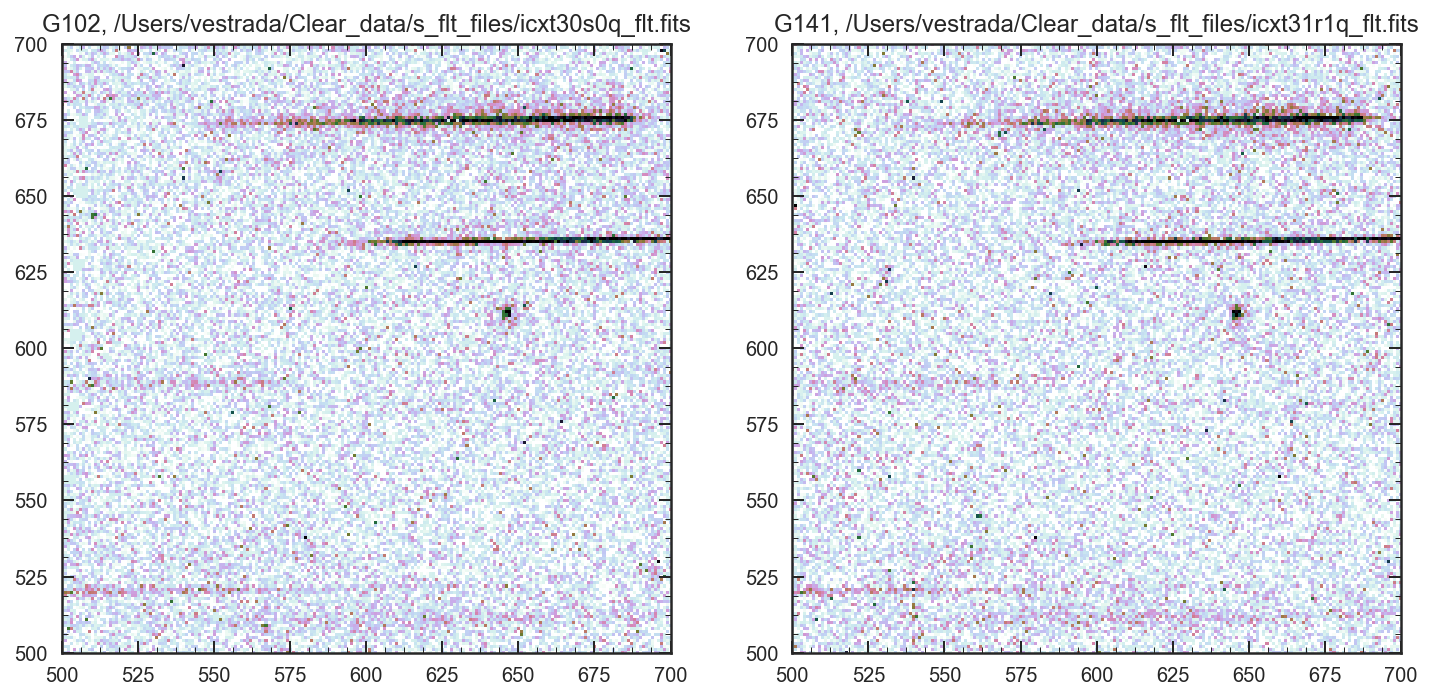

In [5]:

### Show FLT residuals### Show 
fig = plt.figure(figsize=[12,6])
ax = fig.add_subplot(121)
ax.imshow(grp.FLTs[0].grism['SCI'] - grp.FLTs[0].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G102, %s' %(grp.FLTs[0].grism.parent_file))

ax = fig.add_subplot(122)
ax.imshow(grp.FLTs[4].grism['SCI'] - grp.FLTs[4].model, vmin=-0.02, vmax=0.2, cmap='cubehelix_r',
          interpolation='Nearest', origin='lower')
ax.set_title('G141, %s' %(grp.FLTs[4].grism.parent_file))

for ax in fig.axes:
    ax.set_xlim(500,700); ax.set_ylim(500,700)

In [6]:

## Fit parameters## Fit p 
pzfit, pspec2, pline = get_redshift_fit_defaults()

# Redshift fit
pzfit ['zr'] = [0.5, 2.4]
pzfit['dz'] = [0.005, 0.0005]

# Drizzled line maps
pline = {'kernel': 'square', 'pixfrac': 0.6, 'pixscale': 0.06, 'size': 20}

# Full rectified 2D spectrum
pspec2 = {'NY': 20, 'dlam': 40, 'spatial_scale': 1}

In [10]:
id=41520
beams = grp.get_beams(id, size=80)
mb = MultiBeam(beams, fcontam=1, group_name='ers-grism')
out = mb.run_full_diagnostics(pzfit=pzfit, pspec2=pspec2, pline=pline,
                              GroupFLT=grp, prior=None, verbose=False)

First iteration: z_best=1.6129

 Zoom iteration: z_best=1.6136



TypeError: NumPy boolean array indexing assignment requires a 0 or 1-dimensional input, input has 2 dimensions

In [8]:
beams

In [11]:
g102_wave = list(mb.oned_spectrum()['G102']['wave'])
g141_wave = list(mb.oned_spectrum()['G141']['wave'])

In [12]:
IDX = [U for U in range(len(g102_wave)) if 8000< g102_wave[U] <11300]
IDC = [U for U in range(len(g141_wave)) if 11100< g141_wave[U] <16700]

<ErrorbarContainer object of 3 artists>

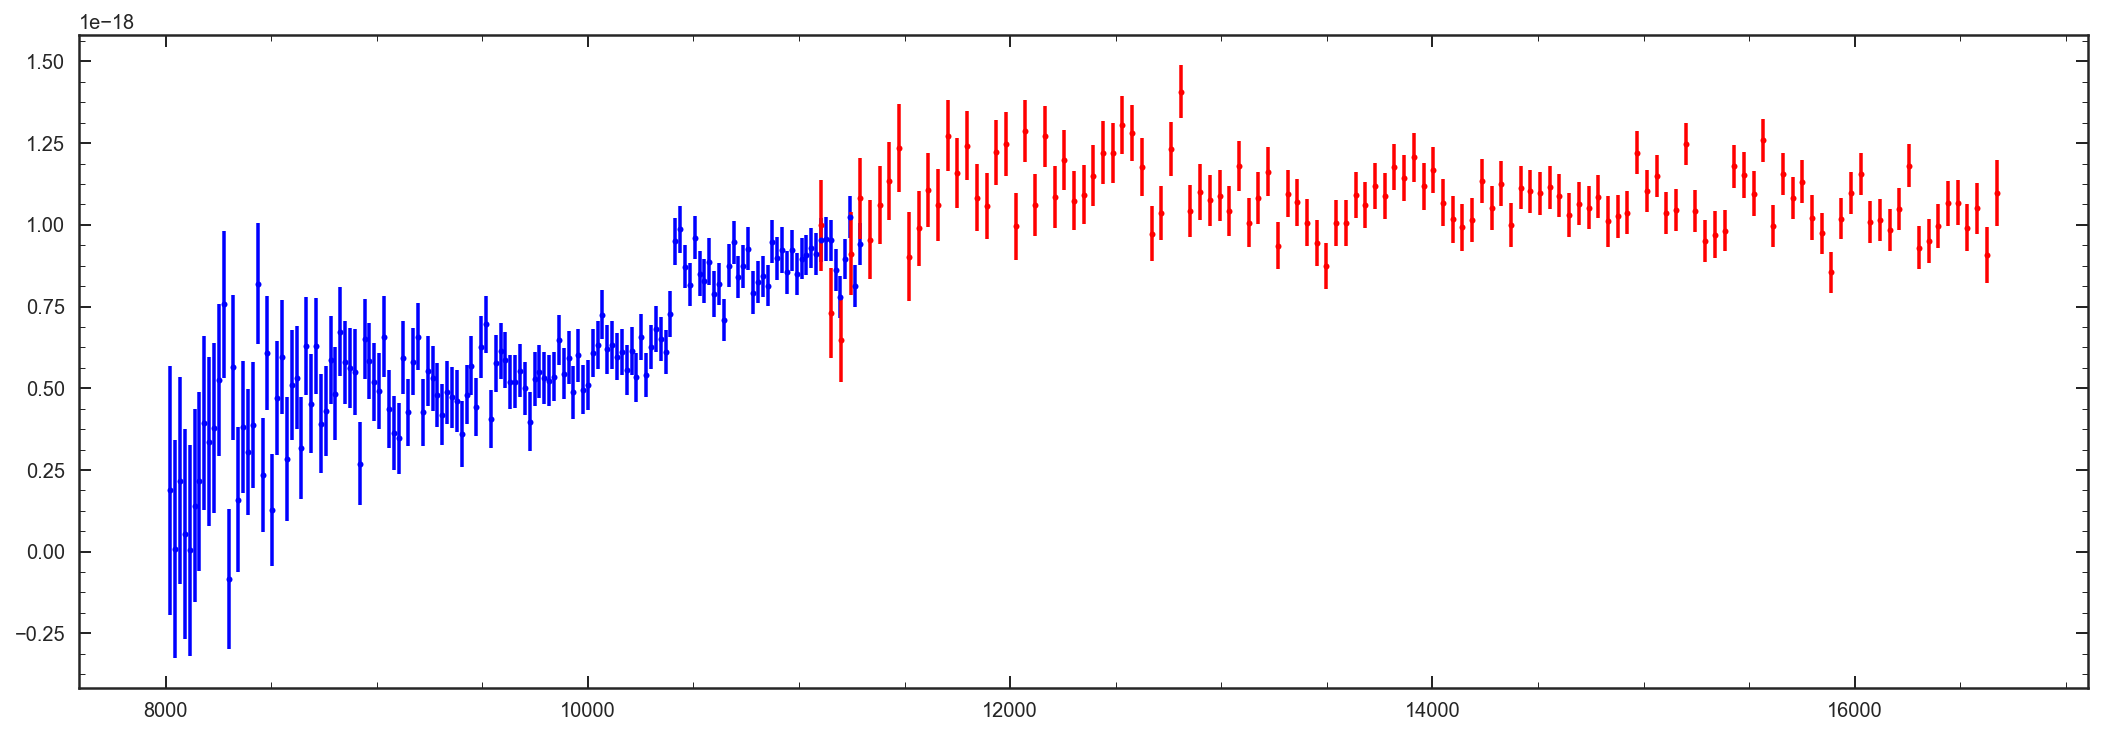

In [13]:
plt.figure(figsize=[18,6])
plt.errorbar(mb.oned_spectrum()['G102']['wave'][IDX],mb.oned_spectrum()['G102']['flux'][IDX] / mb.oned_spectrum()['G102']['flat'][IDX],
             mb.oned_spectrum()['G102']['err'][IDX] / mb.oned_spectrum()['G102']['flat'][IDX],
             linestyle='None', marker='o', markersize=3, color='b')
plt.errorbar(mb.oned_spectrum()['G141']['wave'][IDC],mb.oned_spectrum()['G141']['flux'][IDC] / mb.oned_spectrum()['G141']['flat'][IDC],
            mb.oned_spectrum()['G141']['err'][IDC] / mb.oned_spectrum()['G141']['flat'][IDC],
             linestyle='None', marker='o', markersize=3, color='r')


In [58]:
mb.oned_spectrum()['G102']

wave,flux,err,flat
Angstrom,ct / s,ct / s,Angstrom cm2 ct / erg
float64,float64,float64,float64
7700.0,0.0,0.0,0.0
7723.0,0.0,0.0,0.0
7746.0,0.0,0.0,0.0
7769.0,-0.0041270102266607505,0.0312280461555222,1.3421672973704278e+16
7792.0,0.018911925090525646,0.021297314068102455,1.5871447214542604e+16
7815.0,0.037488782102728914,0.019371587925181045,1.8882760683095308e+16
7838.0,-0.004356020078994011,0.01685327293950242,2.2445809239119748e+16
7861.0,0.0015539365394829571,0.01824260175872689,2.5809298806839516e+16


In [15]:
np.save('multifit-g102',[mb.oned_spectrum()['G102']['wave'][IDX],mb.oned_spectrum()['G102']['flux'][IDX] / mb.oned_spectrum()['G102']['flat'][IDX],
             mb.oned_spectrum()['G102']['err'][IDX] / mb.oned_spectrum()['G102']['flat'][IDX]])
np.save('multifit-g141',[mb.oned_spectrum()['G141']['wave'][IDC],mb.oned_spectrum()['G141']['flux'][IDC] / mb.oned_spectrum()['G141']['flat'][IDC],
             mb.oned_spectrum()['G141']['err'][IDC] / mb.oned_spectrum()['G141']['flat'][IDC]])

# cleaning test

In [2]:
files = glob.glob('/Users/vestrada/Clear_data/flt_files/*flt.fits')
info = griz_utils.get_flt_info(files)
visits, filters = grizli.utils.parse_flt_files(info=info, uniquename=True)

ERSPRIME-cxt-20-092.0-F105W 2
ERSPRIME-cxt-21-092.0-F105W 2
ERSPRIME-cxt-19-122.0-F105W 2
ERSPRIME-cxt-22-142.0-F105W 2
ERSPRIME-cxt-23-142.0-F105W 2
ERSPRIME-cxt-20-092.0-G102 4
ERSPRIME-cxt-21-092.0-G102 4
ERSPRIME-cxt-19-122.0-G102 4
ERSPRIME-cxt-22-142.0-G102 4
ERSPRIME-cxt-23-142.0-G102 4
GDN11-cat-11-015.0-F105W 2
GDN11-cat-11-015.0-G102 4
GDN12-cat-12-010.0-F105W 2
GDN12-cat-12-010.0-G102 4
GDN17-cat-17-345.0-F105W 2
GDN17-cat-17-345.0-G102 4
GDN18-cat-18-175.0-F105W 2
GDN18-cat-18-175.0-G102 4
GDN19-cat-19-173.0-F105W 2
GDN19-cat-19-173.0-G102 4
GDN20-cat-20-173.0-F105W 2
GDN20-cat-20-173.0-G102 4
GDN21-cat-21-345.0-F105W 2
GDN21-cat-21-345.0-G102 4
GDN22-cat-22-172.0-F105W 2
GDN22-cat-22-172.0-G102 4
GDN23-cat-23-195.0-F105W 2
GDN23-cat-23-195.0-G102 4
GDN25-cat-25-195.0-F105W 2
GDN25-cat-25-195.0-G102 4
GDN26-cat-26-345.0-F105W 2
GDN26-cat-26-345.0-G102 4
GDN3-cat-03-008.0-F105W 2
GDN3-cat-03-008.0-G102 4
GDN6-cat-06-349.0-F105W 2
GDN6-cat-06-349.0-G102 4
GDN7-cat-07-335.0-F1

In [3]:
for i in range(4):
    print(dict(visits[i]))

{'files': ['icxt20faq_flt.fits', 'icxt20feq_flt.fits'], 'product': 'ersprime-cxt-20-092.0-f105w'}
{'files': ['icxt21baq_flt.fits', 'icxt21bfq_flt.fits'], 'product': 'ersprime-cxt-21-092.0-f105w'}
{'files': ['icxt19o9q_flt.fits', 'icxt19odq_flt.fits'], 'product': 'ersprime-cxt-19-122.0-f105w'}
{'files': ['icxt22ppq_flt.fits', 'icxt22ptq_flt.fits'], 'product': 'ersprime-cxt-22-142.0-f105w'}


In [7]:
from grizli.prep import process_direct_grism_visit

In [9]:
for i in range(2):
    status = process_direct_grism_visit(direct=visits[i], grism=visits[i+2])

IndexError: list index out of range

In [24]:
visits

[OrderedDict([('files', ['icxt20faq_flt.fits', 'icxt20feq_flt.fits']),
              ('product', 'ersprime-cxt-20-092.0-f105w')]),
 OrderedDict([('files', ['icxt21baq_flt.fits', 'icxt21bfq_flt.fits']),
              ('product', 'ersprime-cxt-21-092.0-f105w')]),
 OrderedDict([('files', ['icxt19o9q_flt.fits', 'icxt19odq_flt.fits']),
              ('product', 'ersprime-cxt-19-122.0-f105w')]),
 OrderedDict([('files', ['icxt22ppq_flt.fits', 'icxt22ptq_flt.fits']),
              ('product', 'ersprime-cxt-22-142.0-f105w')]),
 OrderedDict([('files', ['icxt23pyq_flt.fits', 'icxt23q2q_flt.fits']),
              ('product', 'ersprime-cxt-23-142.0-f105w')]),
 OrderedDict([('files',
               ['icxt20f7q_flt.fits',
                'icxt20f8q_flt.fits',
                'icxt20fbq_flt.fits',
                'icxt20fdq_flt.fits']),
              ('product', 'ersprime-cxt-20-092.0-g102')]),
 OrderedDict([('files',
               ['icxt21b7q_flt.fits',
                'icxt21b8q_flt.fits',
        

In [11]:
visits[1]

OrderedDict([('files', ['icxt21baq_flt.fits', 'icxt21bfq_flt.fits']),
             ('product', 'ersprime-cxt-21-092.0-f105w')])

In [13]:
file = os.path.basename(files[0])

In [14]:
glob(os.path.join(path,file)+'*')

NameError: name 'path' is not defined

In [15]:
from hsaquery import query, overlaps


In [33]:
parent = query.run_query(box=None, proposid=[14227], instruments=['WFC3-IR'], 
                         extensions=['FLT'], filters=['G102'],extra=[])

In [27]:
extra = query.DEFAULT_EXTRA # ignore calibrations, etc.

In [20]:
extra += ["TARGET.TARGET_NAME LIKE 'WFC3-ERSII-G01'"]

Parse 1
Parse 2
Parse 3
Parse 4
Parse 5
Parse 6
Parse 7
Parse 8
Parse 9
Parse 10
Parse 11
Parse 12
Parse 13
Parse 14
Parse 15
Parse 16
Parse 17
Parse 18
Parse 19
Parse 20
Parse 21
Parse 22
Parse 23
Parse 24
Parse 25
Parse 26
Parse 27
Parse 28
Parse 29
Parse 30
Parse 31
Parse 32
Parse 33
Parse 34
Parse 35
Parse 36
Parse 37
Parse 38
Parse 39
Parse 40
Parse 41
Parse 42
Parse 43
Parse 44
Parse 45
Parse 46
Parse 47
Parse 48
Parse 49
Parse 50
Parse 51
Parse 52
Parse 53
Parse 54
Parse 55
Parse 56
Parse 57
Parse 58
Parse 59
Parse 60
Parse 61
Parse 62
Parse 63
Parse 64
Parse 65
Parse 66
Parse 67
Parse 68
Parse 69
Parse 70
Parse 71
Parse 72
Parse 73
Parse 74
Parse 75
Parse 76
Parse 77
Parse 78
Parse 79
Parse 80
Parse 81
Parse 82
Parse 83
Parse 84
Parse 85
Parse 86
Parse 87
Parse 88
Parse 89
Parse 90
Parse 91
Parse 92
Parse 93
Parse 94
Parse 95
Parse 96
Parse 97
Parse 98
Parse 99
Parse 100
Parse 101
Parse 102
Parse 103
Parse 104
Parse 105
Parse 106
Parse 107
Parse 108
Parse 109
Parse 110
Parse 11

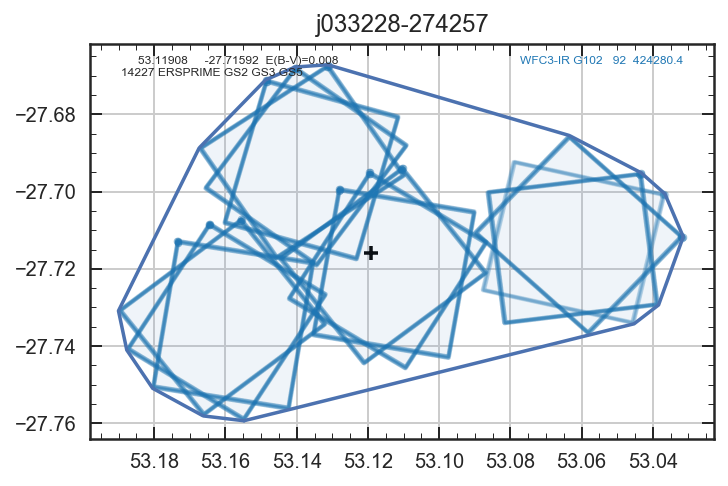

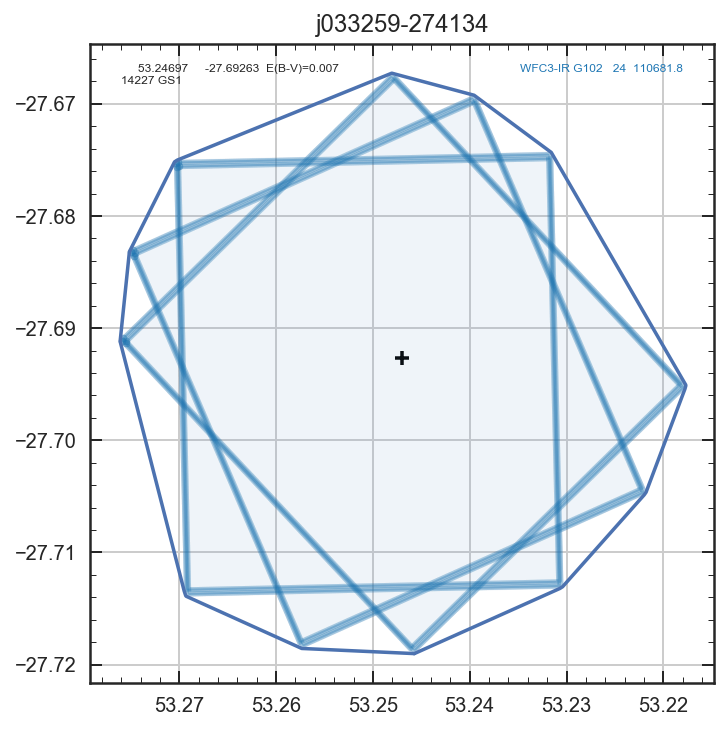

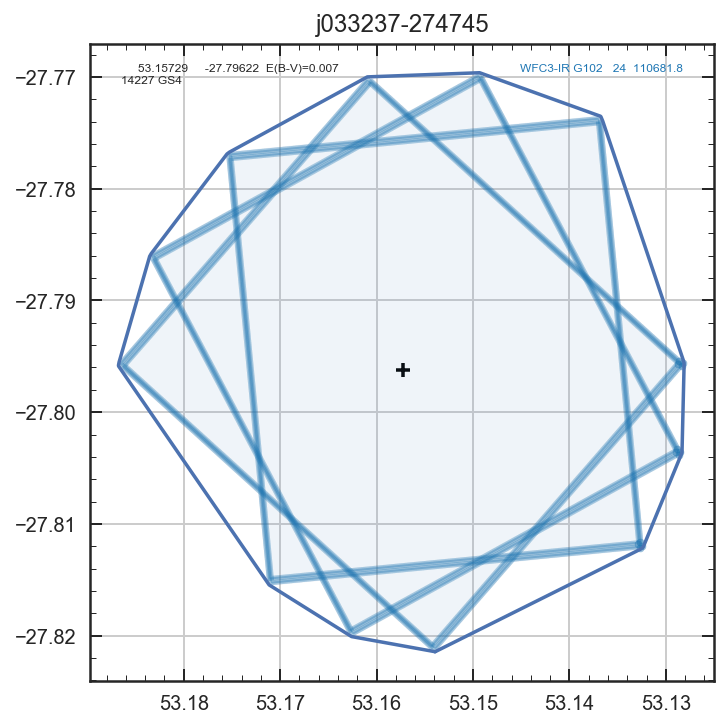

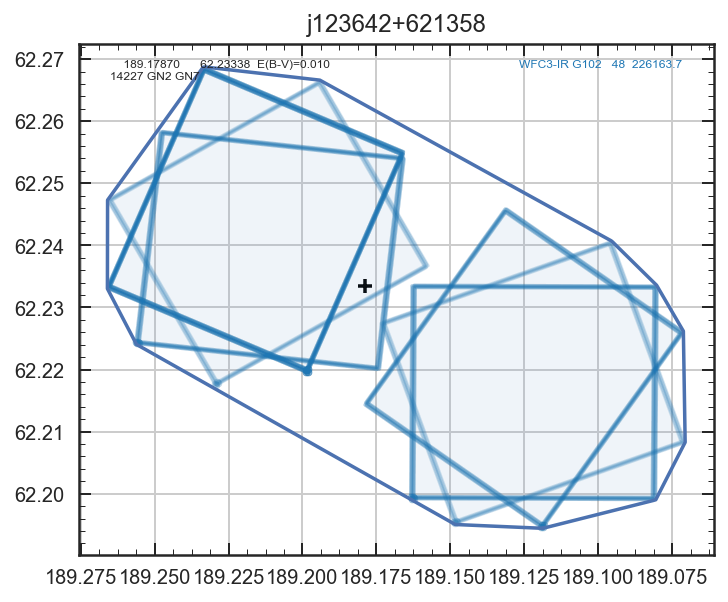

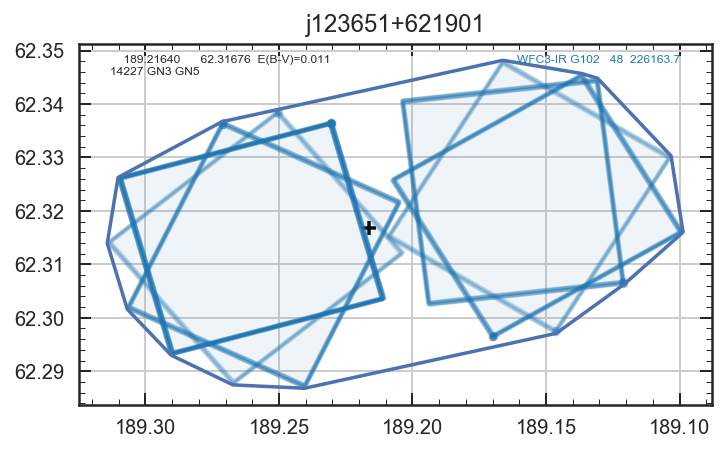

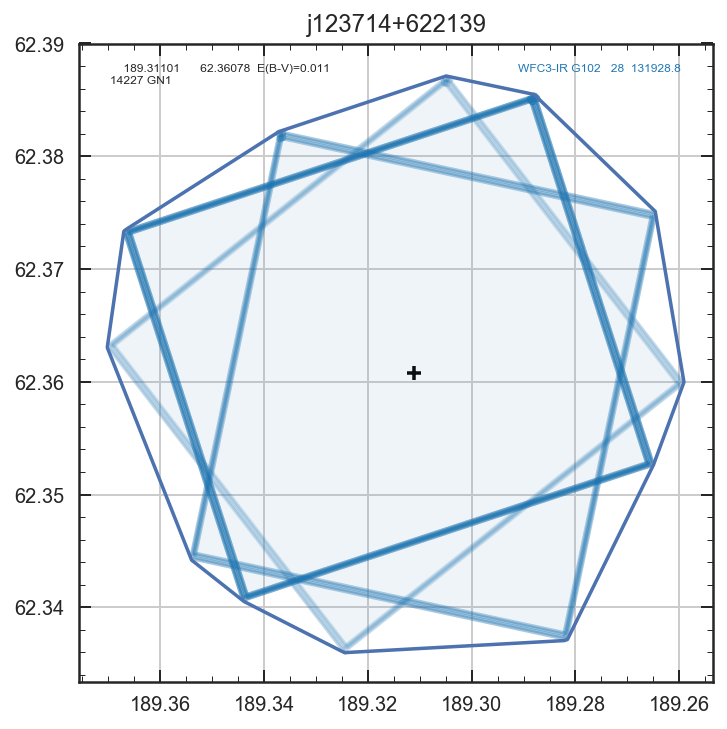

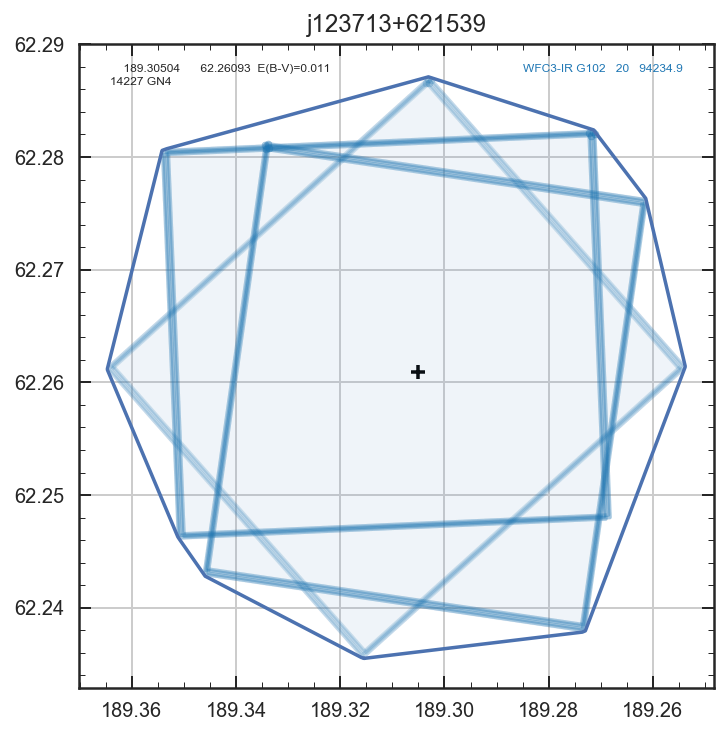

In [34]:
tabs = overlaps.find_overlaps(parent, buffer_arcmin=0.01, 
                              filters=['G102', 'G141'], 
                              proposid=[14227], instruments=['WFC3-IR'], 
                              extra=[], close=False)

In [35]:
# Summary of the tables you just generated
foot_files = glob.glob('j[02]*footprint.fits')
print('Footprint files: ', foot_files)

print('\n# id            ra         dec        e(b-v)   filters')
for tab in tabs:
    print('{0}  {1:.5f}  {2:.5f}   {3:.4f}   {4}'.format(tab.meta['NAME'], tab.meta['RA'], 
                                                 tab.meta['DEC'], tab.meta['MW_EBV'],
                                                  ','.join(np.unique(tab['filter']))))

Footprint files:  ['j033228-274257_footprint.fits', 'j033237-274745_footprint.fits', 'j033259-274134_footprint.fits']

# id            ra         dec        e(b-v)   filters
j033228-274257  53.11908  -27.71592   0.0079   G102
j033259-274134  53.24697  -27.69263   0.0067   G102
j033237-274745  53.15729  -27.79622   0.0066   G102
j123642+621358  189.17870  62.23338   0.0104   G102
j123651+621901  189.21640  62.31676   0.0107   G102
j123714+622139  189.31101  62.36078   0.0108   G102
j123713+621539  189.30504  62.26093   0.0105   G102


In [41]:
HOME_PATH = '/Users/vestrada/Clear_data/grizli_flts'
root = 'j033228-274257'


In [44]:
auto_script.go(root=root, maglim=[19,20], HOME_PATH=HOME_PATH, reprocess_parallel=True, 
                   s3_sync=False, run_fit=False, only_preprocess=False, 
                   is_parallel_field=False)

No FL[TC] files found!


False

In [ ]:
os.chdir(HOME_PATH)
auto_script.fetch_files(field_root=root, HOME_PATH=HOME_PATH, remove_bad=True)

In [50]:
os.chdir(HOME_PATH)

# Demo combining by PA / filter.  # Demo  

# Here it actually gets a bit confused because multiple F098M exposures 
# were taken at the same PA but shouldn't be associated with the grism exposures.
print(os.chdir(os.path.join(HOME_PATH, root, 'Prep')))
visits, all_groups, info = auto_script.parse_visits(field_root=root, 
                                                    HOME_PATH=HOME_PATH, use_visit=True, 
                                                    combine_same_pa=True)

print('\n ====== \n')
for visit in visits:
    print('{0:30} {1:>2d}'.format(visit['product'], len(visit['files'])))

None


UnboundLocalError: local variable 'has_columns' referenced before assignment

In [47]:

############################# 
### Alignment & mosaics    
os.chdir(os.path.join(HOME_PATH, root, 'Prep'))

# Alignment reference catalogs, searched in this order
catalogs = ['PS1','SDSS','GAIA','WISE'] 

# This script will do all the preprocessing of the grism *and* imaging visits 
# found in your archive query.
auto_script.preprocess(field_root=root, HOME_PATH=HOME_PATH, 
                       make_combined=False, catalogs=catalogs, use_visit=True)